In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *
from tqdm import tqdm

%matplotlib inline

In [279]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13)# | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]
track_id = selected_truth.particle_id.unique()[1323]
track = selected_truth[selected_truth.particle_id == valid_tracks[101]]

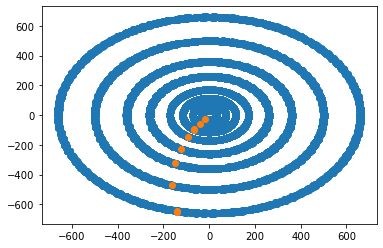

In [281]:
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
ax.plot(track.tx, track.ty, 'o')
plt.show()

In [5]:
def find_module_ids_with_hits(hits, truth, track_id, volume_id, layer_id):
    """
    Returns a numpy array with module_ids of the hits, given track_id, volume_id and layer_id.
    """
    ret = hits.loc[(hits.volume_id == volume_id) & (hits.layer_id == layer_id) & (truth.particle_id == track_id)].module_id
    return np.array(ret)

To find out how each layer should be padded accordingly (because all layers should in the end image be of length = max_length) we need to take the (max_length - layers_length) / 2

In [266]:
def get_layer_info(hits, truth, volume_ids=[8, 13, 17]):
    """
    Returns the information of how many modules in each layer and volume.
    """
    volume_ids = [8, 13, 17]
    layer_info = []
    for v_id in volume_ids:
        for l_id in hits.loc[hits.volume_id == v_id].layer_id.unique():
            l = max(hits.loc[(hits.volume_id == v_id) & (hits.layer_id == l_id)].module_id.unique())
            layer_info.append((v_id, l_id, l))
    return layer_info

def create_masked_image(hits, truth, track_id, max_length, volume_ids=[8, 13, 17]):
    """
    Returns a masked image of the track
    """
    layer_info = get_layer_info(hits, truth, volume_ids)
    nr_layers = len(layer_info)
    masked_image = np.zeros((max_length, nr_layers))
    for i in range(nr_layers):
        layer_length = layer_info[i][2]
        pad_length = int((max_length - layer_length) / 2) - 1
        #print("Layer length:", layer_length, "Pad length:", pad_length)
        #print("Volume id:", layer_info[i][0], "Layer id:", layer_info[i][1])
        module_ids = find_module_ids_with_hits(hits, truth, track_id, layer_info[i][0], layer_info[i][1])
        if len(module_ids) > 0:
            mean_id = int(np.mean(module_ids))
            masked_image[mean_id + pad_length, i] += 1
    return masked_image

In [224]:
get_layer_info(hits, truth)

[(8, 2, 224),
 (8, 4, 448),
 (8, 6, 728),
 (8, 8, 1092),
 (13, 2, 840),
 (13, 4, 1176),
 (13, 6, 1638),
 (13, 8, 2142),
 (17, 2, 2520),
 (17, 4, 3192)]

This function filters the tracks such that we only look at track ids which are guaranteed to have atleast n hits.

In [177]:
def select_valid_tracks(hits, truth, hits_threshhold=10):
    cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
    tracks = truth.loc[cond].particle_id.unique()
    valid_tracks = []
    for track in tracks:
        if track == 0:
            continue
        #nr_hits = truth.loc[cond & (truth.particle_id == track)].shape[0]
        invalid_track = False
        volume_ids = [8, 13, 17]
        nr_hits = 0
        for v_id in volume_ids:
            for l_id in hits.loc[hits.volume_id == v_id].layer_id.unique():
                h = find_module_ids_with_hits(hits, truth, track, v_id, l_id)
                if len(h) > 0:
                    nr_hits += 1
                else:
                    invalid_track = True
        
        
        if nr_hits >= hits_threshhold and not invalid_track:
            valid_tracks.append(track)
    return valid_tracks

In [209]:
valid_tracks = select_valid_tracks(hits, truth, 10)

In [210]:
len(valid_tracks)

1086

In [289]:
volume_ids = [8, 13, 17]
for v_id in volume_ids:
    for l_id in hits.loc[hits.volume_id == v_id].layer_id.unique():
        h = find_module_ids_with_hits(hits, truth, valid_tracks[39], v_id, l_id)
        print(h)

[97]
[194]
[315]
[394]
[363]
[452]
[552]
[620]
[731]
[623]


In [211]:
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
max_length = max(hits.loc[cond].module_id.unique())
print("Dimension of image:", max_length, "x", 10)

Dimension of image: 3192 x 10


In [181]:
train_X = np.ndarray(shape=(len(valid_tracks), max_length, 10, 1))
train_y = np.empty((0, 1))

In [ ]:
i = j
for track_id in tqdm(valid_tracks):
    if track_id == 0:
        continue
    image = create_masked_image(hits, truth, track_id, max_length)
    train_X[i] = np.reshape(image, (image.shape[0], image.shape[1], 1))
    i += 1
    t = truth.loc[cond & (truth.particle_id == track_id)]
    px = t['tpx'].mean()
    py = t['tpy'].mean()
    p = np.sqrt(px**2 + py**2)
    train_y = np.append(train_y, [p])

In [215]:
train_y = np.reshape(train_y, (len(train_y), 1))
#train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], train_X.shape[2], 1))

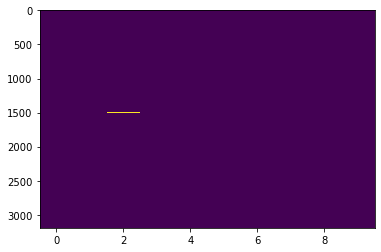

In [288]:
k = 106
im = create_masked_image(hits, truth, valid_tracks[k], max_length)#np.reshape(train_X2[k], (train_X2[k].shape[0], train_X2[k].shape[1]))#
im = im.astype(int)
plt.imshow(np.reshape(im, (im.shape[0], im.shape[1])), aspect="auto")
plt.savefig('myimage.svg', format='svg', dpi=1200)

In [194]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [197]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation="relu", input_shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3])),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(20, activation="relu"),
        layers.Dense(1)
    ])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.00001) #0.00001 works good
    model.compile(loss='mse', optimizer="adam")
    return model

In [216]:
model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 3190, 8, 8)        80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1595, 4, 8)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1593, 2, 16)       1168      
_________________________________________________________________
flatten_10 (Flatten)         (None, 50976)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                1019540   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 1,020,809
Trainable params: 1,020,809
Non-trainable params: 0
___________________________________________

In [218]:
EPOCHS = 1000
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y, validation_split=0.1, epochs=EPOCHS) 

(1893, 3192, 10, 1)
(1893, 1)
Train on 1703 samples, validate on 190 samples
Epoch 1/1000
1703/1703 [==============================] - 4s 2ms/step - loss: 4.1906 - val_loss: 0.4422
Epoch 2/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 4.0378 - val_loss: 0.3257
Epoch 3/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 3.8891 - val_loss: 0.4249
Epoch 4/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 3.7960 - val_loss: 0.4423
Epoch 5/1000
1703/1703 [==============================] - 4s 2ms/step - loss: 3.5158 - val_loss: 0.6887
Epoch 6/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 3.3540 - val_loss: 0.7372
Epoch 7/1000
1703/1703 [==============================] - 4s 2ms/step - loss: 3.1118 - val_loss: 0.6226
Epoch 8/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 2.8589 - val_loss: 0.9202
Epoch 9/1000
1703/1703 [==============================] - 4s 2ms/step - loss: 2.6687 - val_

1703/1703 [==============================] - 3s 2ms/step - loss: 0.0345 - val_loss: 0.5500
Epoch 79/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0283 - val_loss: 0.5334
Epoch 80/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0246 - val_loss: 0.5829
Epoch 81/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0212 - val_loss: 0.5317
Epoch 82/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0191 - val_loss: 0.5694
Epoch 83/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0163 - val_loss: 0.5419
Epoch 84/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0157 - val_loss: 0.5524
Epoch 85/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0202 - val_loss: 0.5506
Epoch 86/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0273 - val_loss: 0.5042
Epoch 87/1000
1703/1703 [==============================] - 3s 2ms/ste

1703/1703 [==============================] - 3s 2ms/step - loss: 0.0120 - val_loss: 0.5480
Epoch 156/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0105 - val_loss: 0.5335
Epoch 157/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0094 - val_loss: 0.5428
Epoch 158/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0112 - val_loss: 0.5116
Epoch 159/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0156 - val_loss: 0.5212
Epoch 160/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0191 - val_loss: 0.5160
Epoch 161/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0285 - val_loss: 0.5182
Epoch 162/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0361 - val_loss: 0.5173
Epoch 163/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0668 - val_loss: 0.4626
Epoch 164/1000
1703/1703 [==============================] - 3

1703/1703 [==============================] - 3s 2ms/step - loss: 0.0071 - val_loss: 0.5242
Epoch 233/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0070 - val_loss: 0.5442
Epoch 234/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0077 - val_loss: 0.5609
Epoch 235/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0101 - val_loss: 0.5553
Epoch 236/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0124 - val_loss: 0.5313
Epoch 237/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0204 - val_loss: 0.5906
Epoch 238/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0241 - val_loss: 0.4926
Epoch 239/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0562 - val_loss: 0.6286
Epoch 240/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.1116 - val_loss: 0.6680
Epoch 241/1000
1703/1703 [==============================] - 3

1703/1703 [==============================] - 3s 2ms/step - loss: 0.2926 - val_loss: 0.8630
Epoch 310/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.3746 - val_loss: 0.7943
Epoch 311/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.1594 - val_loss: 0.7871
Epoch 312/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0773 - val_loss: 0.9904
Epoch 313/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.3253 - val_loss: 0.8386
Epoch 314/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.1377 - val_loss: 1.1055
Epoch 315/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0741 - val_loss: 0.8416
Epoch 316/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0599 - val_loss: 0.9233
Epoch 317/1000
1703/1703 [==============================] - 3s 2ms/step - loss: 0.0535 - val_loss: 0.8686
Epoch 318/1000
1703/1703 [==============================] - 3

KeyboardInterrupt: 

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [203]:
i = 421
pred = model.predict(np.reshape(train_X[i], (1, max_length, 10, 1)))
real = train_y[i]
print("pred/real", pred, real)

pred/real [[0.9020727]] [1.33578894]
